# Learning Spark - Demos
### Yu Feng
---

### Environment Variables Setting

In [1]:
import os
import sys

def configure_spark(spark_home=None, pyspark_python=None):
    spark_home = spark_home or "/usr/local/spark"
    os.environ['SPARK_HOME'] = spark_home
    
    # Add the PySpark directories to the Python path:
    sys.path.insert(1, os.path.join(spark_home, 'python'))
    sys.path.insert(1, os.path.join(spark_home, 'python', 'build'))
    sys.path.insert(1, os.path.join(spark_home, 'python', 'lib','pyspark.zip'))
    sys.path.insert(1, os.path.join(spark_home, 'python', 'lib','py4j-0.10.1-src.zip'))
    
    os.environ['PYTHONPATH'] = os.path.join(spark_home, 'python', 'lib','py4j-0.10.1-src.zip')
    
    # If PySpark isn't specified, use currently running Python binary:
    pyspark_python = pyspark_python or sys.executable
    os.environ['PYSPARK_PYTHON'] = pyspark_python

configure_spark()

In [2]:
os.environ['JAVA_HOME'] = "/usr/lib/jvm/java-1.7.0-openjdk-amd64"

# Demo 1: Programming with RDDs

The most traditional tasks for Spark

In [3]:
from pyspark import SparkConf, SparkContext

conf = SparkConf().setMaster("local").setAppName("My App") 
sc = SparkContext(conf = conf)

## RDD (resilient distributed dataset)
* Spilt into multiple partitions
* Be computed on different nodes of the cluster

In [4]:
# Create an RDD from external dataset
lines = sc.textFile("alice30.txt") 

In [5]:
# Create an RDD from an existing colleciton
localLines = sc.parallelize(["pandas", "i like pandas"]) 

## RRD Operations: Actions and Transformation

### - Actions: compute results based on RDD, return it to driver program or save it to external storage system (e.g. HDFS)

* .count() - Count the number of items in this RDD
* .first() - First item in this RDD
* .take() - Return first n lines 
* .collect() - Return all lines, should not used in large datasets
* .reduce()

In [6]:
print lines.count()
print lines.first()

3599
                ALICE'S ADVENTURES IN WONDERLAND


In [7]:
for line in lines.take(10): 
    print line

                ALICE'S ADVENTURES IN WONDERLAND

                          Lewis Carroll

               THE MILLENNIUM FULCRUM EDITION 3.0




                            CHAPTER I


In [8]:
nums = sc.parallelize([1, 2, 3, 4]) 
sum = nums.reduce(lambda x, y: x + y)
print sum 

10


### - Transformation: construct a new RDD from a previous one

* .filter() - takes a funtion and return the elements fulfill the requirements
* .map() - takes a function and return new values for each elements
* .distinct(), .union(), .intersection(), .substract() - mathematical sets

![Image1](images/mathsetop.PNG)

In [9]:
# Return an entire new RDD
pythonLines = lines.filter(lambda line: "Queen" in line)

#for line in pythonLines.collect():
#    print line

print pythonLines.count()

74


In [10]:
kingLines = lines.filter(lambda line: "King" in line)
king_queen_lines = pythonLines.union(kingLines)

print king_queen_lines.count()

136


In [11]:
def containsKing(s):
    return "King" in s

kingLines = lines.filter(containsKing)
print kingLines.count()

62


In [12]:
nums = sc.parallelize([1, 2, 3, 4]) 
squared = nums.map(lambda x: x * x).collect() 
print squared

[1, 4, 9, 16]


In [13]:
sc.stop() 

# Demo 2: Programming with DataFrame

DataFrame performs much faster than RDDs

## DataFrames
similar to traditional database

![Image2](images/dataframes-faster.png)

In [14]:
from pyspark.sql import SparkSession

spark = SparkSession \
    .builder \
    .appName("Python Spark SQL basic example") \
    .config("spark.some.config.option", "some-value") \
    .getOrCreate()

In [15]:
# spark is an existing SparkSession
df = spark.read.csv("work-flow/tweet.csv", header=True)
# Displays the content of the DataFrame to stdout
print 'Total: %d' % df.count()
df.show(10)

Total: 3118
+---------+-----------+--------------------+-----+--------------------+
| Latitude|  Longitude|                Time|Label|            Location|
+---------+-----------+--------------------+-----+--------------------+
|55.864237|  -4.251806|Mon Oct 05 08:20:...|    1|   Glasgow  Scotland|
|33.748995| -84.387982|Mon Oct 05 08:20:...|    1|         Atlanta  GA|
|33.448377|-112.074037|Mon Oct 05 08:20:...|    1|     Phoenix Arizona|
|34.000710| -81.034814|Mon Oct 05 08:20:...|    1|Columbia  South C...|
|40.569789| -79.764770|Mon Oct 05 08:20:...|    1|  New Kensington  PA|
|33.748995| -84.387982|Mon Oct 05 08:20:...|    1|         Atlanta  GA|
|35.689197|  51.388974|Mon Oct 05 08:20:...|    1|         IRAN TEHRAN|
|35.125801|-117.985904|Mon Oct 05 08:20:...|    1|  California City CA|
|51.621440|  -3.943646|Mon Oct 05 08:20:...|    1|             swansea|
|33.748995| -84.387982|Mon Oct 05 08:20:...|    1|   Atlanta  GA      |
+---------+-----------+--------------------+-----+--

In [16]:
# spark, df are from the previous example
# Print the schema in a tree format
df.printSchema()

root
 |-- Latitude: string (nullable = true)
 |-- Longitude: string (nullable = true)
 |-- Time: string (nullable = true)
 |-- Label: string (nullable = true)
 |-- Location: string (nullable = true)



In [17]:
# Select only the "Location" column
df.select('Location').show()

+--------------------+
|            Location|
+--------------------+
|   Glasgow  Scotland|
|         Atlanta  GA|
|     Phoenix Arizona|
|Columbia  South C...|
|  New Kensington  PA|
|         Atlanta  GA|
|         IRAN TEHRAN|
|  California City CA|
|             swansea|
|   Atlanta  GA      |
|Vila   Velha   ES...|
|             USA  ma|
|         IRAN TEHRAN|
|         Phoenix  AZ|
|              Lagos |
| Cavite  Philippines|
|      Barrington  RI|
|               Miami|
|                U.K.|
|      Patiala Punjab|
+--------------------+
only showing top 20 rows



In [18]:
# Count people by Location
df.groupBy('Location').count().sort('count', ascending=False).show()

+--------------------+-----+
|            Location|count|
+--------------------+-----+
|              London|   86|
|        Columbia  SC|   34|
|Querétaro Arteaga...|   26|
|Florence  South C...|   25|
|        New York  NY|   24|
|    Myrtle Beach  SC|   24|
|         Atlanta  GA|   24|
|      Wilmington  NC|   22|
|       Charlotte  NC|   22|
|         Norfolk  VA|   20|
|      Charleston  SC|   18|
|      South Carolina|   18|
|          Birmingham|   17|
|               World|   17|
|     London  England|   17|
|         Houston  TX|   16|
| Manchester  England|   15|
|        Greenbelt MD|   15|
|               Earth|   15|
|      Lagos  Nigeria|   14|
+--------------------+-----+
only showing top 20 rows



In [19]:
# Select by location
df.filter(df['Location'] == 'Manchester  England').show()

# Pandas-like syntax
df[df['Location'] == 'Manchester  England'].show()

# Register the DataFrame as a SQL temporary view
df.createOrReplaceTempView("spatialdata")
sqlDF = spark.sql("SELECT * FROM spatialdata WHERE Location == 'Manchester  England' ")
sqlDF.show()

+---------+----------+--------------------+-----+-------------------+
| Latitude| Longitude|                Time|Label|           Location|
+---------+----------+--------------------+-----+-------------------+
|53.480759| -2.242631|Mon Oct 05 08:21:...|    1|Manchester  England|
|53.480759| -2.242631|Mon Oct 05 08:22:...|    1|Manchester  England|
|53.480759| -2.242631|Mon Oct 05 08:22:...|    1|Manchester  England|
|53.480759| -2.242631|Mon Oct 05 08:23:...|    1|Manchester  England|
|53.480759| -2.242631|Mon Oct 05 08:24:...|    1|Manchester  England|
|53.480759| -2.242631|Mon Oct 05 08:28:...|    1|Manchester  England|
|53.480759| -2.242631|Mon Oct 05 08:30:...|    1|Manchester  England|
|53.480759| -2.242631|Mon Oct 05 08:32:...|    1|Manchester  England|
|53.480759| -2.242631|Mon Oct 05 08:33:...|    1|Manchester  England|
|53.480759| -2.242631|Mon Oct 05 08:33:...|    1|Manchester  England|
|53.480759| -2.242631|Mon Oct 05 08:34:...|    1|Manchester  England|
|53.480759| -2.24263

In [20]:
# Convert Spark DataFrame to Pandas
pandas_df = df.toPandas()
print 'Pandas Dataframe: '
print pandas_df.dtypes

# Create a Spark DataFrame from Pandas
spark_df = spark.createDataFrame(pandas_df)
print 'Spark Dataframe: '
print spark_df

Pandas Dataframe: 
Latitude     object
Longitude    object
Time         object
Label        object
Location     object
dtype: object
Spark Dataframe: 
DataFrame[Latitude: string, Longitude: string, Time: string, Label: string, Location: string]


In [21]:
spark.stop()

# Demo 3

## Goal
Find the city with the most cultural infrastructures in Europe

## Data

##### 1. Boundaries/Urban footprints of some of the largest cities in Europe along with the total population for 2013 for those urban areas.

Download 2013 population data for European cities. http://bit.ly/eurostat-urban-audit-database 

##### 2. OpenStreetMap points of interests that have culturally relevant tags

Tag | Score
:--: | :--:
tourism"="artwork" | 5
tourism"="gallery" | 4
amenity"="theatre" | 3
amenity"="arts_centre" | 2
tourism"="museum" | 1


## Tools

#### 1. PySpark

## Table of Contents
 <p><div class="lev1"><a href="#The-Data"><span class="toc-item-num">1&nbsp;&nbsp;</span>The Data</a></div><div class="lev2"><a href="#EuroStat"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>EuroStat</a></div><div class="lev3"><a href="#Exercise:-Getting-Spatial-Boundary-Data"><span class="toc-item-num">1.1.1&nbsp;&nbsp;</span>Exercise: Getting Spatial Boundary Data</a></div><div class="lev2"><a href="#OpenStreetMap/Overpass-API"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>OpenStreetMap/Overpass API</a></div><div class="lev3"><a href="#Exercise:-Getting-to-know-OSM-Data"><span class="toc-item-num">1.2.1&nbsp;&nbsp;</span>Exercise: Getting to know OSM Data</a></div><div class="lev1"><a href="#What-are-we-going-to-do?"><span class="toc-item-num">2&nbsp;&nbsp;</span>What are we going to do?</a></div><div class="lev2"><a href="#What-do-we-mean-by-culture/cultural-score?"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>What do we mean by culture/cultural score?</a></div><div class="lev1"><a href="#GeoPandas"><span class="toc-item-num">3&nbsp;&nbsp;</span>GeoPandas</a></div><div class="lev2"><a href="#OGC-SimpleFeatures"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>OGC SimpleFeatures</a></div><div class="lev3"><a href="#WKT/WKB:-Well-Known-Text-and-Well-Known-Binary"><span class="toc-item-num">3.1.1&nbsp;&nbsp;</span>WKT/WKB: Well Known Text and Well Known Binary</a></div><div class="lev3"><a href="#Implications-for-PySpark-data-de/serialization-&amp;-un/marshalling"><span class="toc-item-num">3.1.2&nbsp;&nbsp;</span>Implications for PySpark data de/serialization &amp; un/marshalling</a></div><div class="lev2"><a href="#Exercise:"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Exercise:</a></div><div class="lev2"><a href="#Create-a-pyspark-dataframe-from-GeoPanadas"><span class="toc-item-num">3.3&nbsp;&nbsp;</span>Create a pyspark dataframe from GeoPanadas</a></div><div class="lev3"><a href="#Exercise"><span class="toc-item-num">3.3.1&nbsp;&nbsp;</span>Exercise</a></div><div class="lev1"><a href="#Lets-look-at-the-POI-data-next"><span class="toc-item-num">4&nbsp;&nbsp;</span>Lets look at the POI data next</a></div><div class="lev1"><a href="#Count-the-number-of-museums-in-Zurich"><span class="toc-item-num">5&nbsp;&nbsp;</span>Count the number of museums in Zurich</a></div><div class="lev2"><a href="#Exercise"><span class="toc-item-num">5.1&nbsp;&nbsp;</span>Exercise</a></div><div class="lev1"><a href="#SQL-is-nice-but..."><span class="toc-item-num">6&nbsp;&nbsp;</span>SQL is nice but...</a></div><div class="lev1"><a href="#Joins,-Spatial-Predicate,-Broadcast-Variables,-UDFs"><span class="toc-item-num">7&nbsp;&nbsp;</span>Joins, Spatial Predicate, Broadcast Variables, UDFs</a></div><div class="lev2"><a href="#Grouping"><span class="toc-item-num">7.1&nbsp;&nbsp;</span>Grouping</a></div><div class="lev2"><a href="#Adding-population-column"><span class="toc-item-num">7.2&nbsp;&nbsp;</span>Adding population column</a></div><div class="lev2"><a href="#Calculating-the-score"><span class="toc-item-num">7.3&nbsp;&nbsp;</span>Calculating the score</a></div><div class="lev1"><a href="#Spatial-Spark"><span class="toc-item-num">8&nbsp;&nbsp;</span>Spatial Spark</a></div><div class="lev2"><a href="#Spatial-Partition"><span class="toc-item-num">8.1&nbsp;&nbsp;</span>Spatial Partition</a></div><div class="lev2"><a href="#Spatial-Range-Query"><span class="toc-item-num">8.2&nbsp;&nbsp;</span>Spatial Range Query</a></div><div class="lev1"><a href="#Perform-Analysis-on-All-Features-and-All-Cities"><span class="toc-item-num">9&nbsp;&nbsp;</span>Perform Analysis on All Features and All Cities</a></div>

In [22]:
import notebook

import os.path, json, io, pandas
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams['figure.figsize'] = (16, 20)

from retrying import retry # for exponential back down when calling TurboOverdrive API

import pyspark.sql.functions as func # resuse as func.coalace for example
from pyspark.sql.types import StringType, IntegerType, FloatType, DoubleType,DecimalType

from geopandas import GeoDataFrame # Loading Boundries Data
from shapely.geometry import Point, Polygon, shape # creating geospatial data
from shapely import wkb, wkt # creating and parsing geospatial data
import overpy # OpenStreetMap API

%matplotlib inline

# make sure nbextensions are installed
notebook.nbextensions.check_nbextension('usability/codefolding', user=True)


import pyspark
sc = pyspark.SparkContext('local[*]')
sqlContext = pyspark.sql.SQLContext(sc)



## EuroStat

European Commission's agency "Eurostat" conducted a Cities (Urban Audit) which is a Data Database containing detailed year-by-year statistics based on objective measurements. They have an incredibly rich and valuable database. The data set we are using defines cities in terms of two distinct areas (with possibly a third area - "Kernel" - for large cities like London and Paris). The regions are "Core City" and "Large Urban Zone". There is a great article that explains this in detail (Cities explained by EuroStat)[http://ec.europa.eu/eurostat/statistics-explained/index.php/European_cities_-_spatial_dimension] This is extremely important for our analysis as we want to do spatial analysis bounded by a well defined region whose population can be reliable defined. The EuroStat Database will give us this.

### Exercise: Getting Spatial Boundary Data

Just spend 5 minutes looking at the database for Urban Audit and try to download 2013 population data for European cities. http://bit.ly/eurostat-urban-audit-database WARNING: you can get lost on their website and emerge 2 hours later wondering where all the time went.

## OpenStreetMap/Overpass API

For the Cultural data we are going to use OpenStreetMap. Now there are many ways to obtain OSM data. we will use the Overpass Turbo. Overpass turbo is a web based data mining tool for OpenStreetMap. You find it at http://overpass-turbo.eu. It runs any kind of Overpass API query and shows the results on an interactive map. The source code is found on https://github.com/tyrasd/overpass-turbo. A huge thanks goes to Roland who created the Overpass API, without which this tool wouldn't exist. The Overpass API (formerly known as OSM Server Side Scripting, or OSM3S) is a read-only API that serves up custom selected parts of the OSM map data. It acts as a database over the web: the client sends a query to the API and gets back the data set that corresponds to the query. Unlike the main API, which is optimized for editing, Overpass API is optimized for data consumers that need a few elements within a glimpse or up to roughly 100 million elements in some minutes, both selected by search criteria like e.g. location, type of objects, tag properties, proximity, or combinations of them. It acts as a database backend for various services. See [Overpass API Wiki page](http://wiki.openstreetmap.org/wiki/Overpass_API) for more details.

We will use Overpass API to download POI data of cultural relevance. To understand the Overpass API have a look at the quick Overpass query language guide here: http://wiki.openstreetmap.org/wiki/Overpass_API/Language_Guide 

### Exercise: Getting to know OSM Data

Just spend 5-10 minutes looking at Overpass API. Try to Query datasets like all the museums. To gain a better understanding of the OSM Tags and meanings behind them look at the Tag Features Wiki pages via Tag Info Website: http://taginfo.openstreetmap.org/keys If you are interested in reading more about a key you can click on it then go to wiki tab an click on the wiki page in your language of choice. *Hint* there is a link to the Turbo Overpass page on the site too.


# What are we going to do?

We will build a data processing pipeline that takes our data sources performs aggregations by precise boundaries. Then run a weighted algorithm to calculate a "cultural" score for each city normalized by its total population. So the pipeline is something like this:

![](images/sketch.png)

## What do we mean by culture/cultural score?

This is a completely subjective and our algorithm is therefore only meant as an excuse to have fun learning PySpark and Spatial Analysis. We collect data from OpenStreetMap that seems culturally relevant. These include the following tags:

    tourism"="artwork"
    tourism"="gallery"
    amenity"="theatre"
    amenity"="arts_centre"
    tourism"="museum"

We will also assign different weights to each tag. From 1 to 5. The tags above are listed from highest (artwork) to lowest (museum). This should make our analysis interesting. We will calculate a score by performing a weighted count for each of the sites found per city. Finally we will normalize our count by dividing it by the total population of the city.

In [23]:
### Helper functions

# given shapely bounds return bbox compatiable with overpass turbo openstreetmap API
def bbox(bounds):
    return (bounds[1],bounds[0],bounds[3],bounds[2])

# given an openstreetmap node retrun a GeoJSON feature
def nodeToFeature(node):
    properties = node.tags
    properties['wkt'] = Point(node.lon, node.lat).wkt
    return {
        "type": "Feature",
        "properties": properties,
        "geometry": {
            "type": "Point",
            "coordinates": [
                float(node.lon),
                float(node.lat)
            ]
        }
    }

# given an array of nodes return an array of GeoJSON features
def nodesToFeatures(nodes):
    """
    :param nodes
    :type nodes from overpy.Result (result.nodes)
    :return:
    """
    features = []
    for node in nodes:
        features.append(nodeToFeature(node))
    return features

def waysToFeatures(ways):
    print ways
    features = []
    return features

In [24]:
# method to handle OverpassTooManyRequests exception from OpenStreetMap/overpass turbo API
def retry_if_overpass_too_many_requests(exception):
    return isinstance(exception, overpy.exception.OverpassTooManyRequests)

# decorator to retry with exponential back off
@retry(wait_exponential_multiplier=2000, 
       wait_exponential_max=60000,
       retry_on_exception=retry_if_overpass_too_many_requests)
def call_overpass_api(q):
    return OVERPASS_API.query(q)

def run_overpass_api(bounding_geo_df):
    local_pois = []
    for index, row in bounding_geo_df.iterrows():
        # For documentation see:
        # http://wiki.openstreetmap.org/wiki/Tag:{key}={value}
        # e.g: http://wiki.openstreetmap.org/wiki/Tag:amenity=theatre
        payload = """
            [out:json][timeout:60];
            (
              node["tourism"="gallery"]%(box)s;
              node["tourism"="artwork"]%(box)s;
              node["tourism"="museum"]%(box)s;
              node["amenity"="arts_centre"]%(box)s;
              node["amenity"="theatre"]%(box)s; 
            );
            out body;""" % {'box': str(bbox(row.geometry.bounds))}
        result = call_overpass_api(payload)
        local_pois.extend(nodesToFeatures(result.nodes))


In [25]:
OVERPASS_API         = overpy.Overpass()
BASE_DIR             = os.path.join(os.path.abspath('.'), 'work-flow')
URBAN_BOUNDRIES_FILE = '06_Europe_Cities_Boundries_with_Labels_Population.geo.json'

# Paths to base datasets that we are using:
URBAN_BOUNDRIES_PATH = os.path.join(BASE_DIR,URBAN_BOUNDRIES_FILE)
POIS_PATH            = os.path.join(BASE_DIR, "pois.json")

# GeoPandas

GeoPandas is an open source project to make working with geospatial data in python easier. GeoPandas extends the datatypes used by pandas to allow spatial operations on geometric types. Geometric operations are performed by shapely. Geopandas further depends on fiona for file access and descartes and matplotlib for plotting.

The goal of GeoPandas is to make working with geospatial data in python easier. It combines the capabilities of pandas and shapely, providing geospatial operations in pandas and a high-level interface to multiple geometries to shapely. GeoPandas enables you to easily do operations in python that would otherwise require a spatial database such as PostGIS.

## OGC SimpleFeatures

A standard that specifies a common storage and access model of mostly two-dimensional geographical data (point, line, polygon, multi-point, multi-line, etc.) The formats were originally defined by the Open Geospatial Consortium (OGC) and described in their Simple Feature Access and Coordinate Transformation Service specifications. 

The standard defines a model for two-dimensional simple features, with linear interpolation between vertices. The data model defined is a hierarchy of classes. This part also defines representation using Well-Known Text (and Binary).

### WKT/WKB: Well Known Text and Well Known Binary

Well-known text (WKT) is a text markup language for representing vector geometry objects on a map, spatial reference systems of spatial objects and transformations between spatial reference systems. A binary equivalent, known as well-known binary (WKB), is used to transfer and store the same information on databases, such as PostGIS, Microsoft SQL Server and DB2. The formats were originally defined by the Open Geospatial Consortium (OGC) and described in their Simple Feature Access and Coordinate Transformation Service specifications.


### Implications for PySpark data de/serialization & un/marshalling

When using pyspark we want have to send data back and forth between master node and the workers which run jobs on the JVM. In order to simplify this rather than sending Python or more precisely Shapely objects we will use WKT. It works with one the libraries I am using today to perform Spatial Joins.


In [26]:
# Load the boundries data
geo_df = GeoDataFrame.from_file(URBAN_BOUNDRIES_PATH)

In [27]:
# Fetch the the POIs but not now
overwritePois = False # <= DON'T Set to True during workshop!        
if overwritePois or not os.path.isfile(POIS_PATH):
    # Write POIs file
    pois = run_overpass_api(geo_df)
    with io.open(POIS_PATH, 'w+', encoding='utf-8') as f:
        f.write(unicode(json.dumps(pois, ensure_ascii= False)))

For the exercise below consult GeoPandas documentation http://geopandas.org/user.html

## Exercise: 

* find out what the schema for the data is?
* plot the geometries?
* print out the wkt version of the geometries
* find out the Spatial Reference System (CRS/SRS) for the GeoDataframe?
* change the reference system to a cartesian system that is suitable for calculating areas
* calculate the total area of the cities we are using HINT: Europe using this CRS: http://spatialreference.org/ref/epsg/3035/

In [28]:
# * find out what the schema for the data is?
geo_df

,ADM0NAME,ADM0_A3,ADM1NAME,ELEVATION,FEATURECLA,GEONAMEID,GN_ASCII,GN_POP,ISO_A2,MEGACITY,NAME,NAMEASCII,POPEU2013,TIMEZONE,UN_FID,URAU_CITY_,geometry
0,Switzerland,CHE,ZHrich,0.0,Admin-1 capital,2657896.0,Zurich,341730.0,CH,1,Zurich,Zurich,380777,Europe/Zurich,468,CH001C,(POLYGON ((8.510730700635937 47.43218569956764...
1,Czech Republic,CZE,Prague,308.0,Admin-0 capital,4548393.0,Prague,2087.0,CZ,1,Prague,Prague,1243201,Europe/Prague,173,CZ001C,(POLYGON ((14.53235520019044 50.17216119994004...
2,Bulgaria,BGR,Grad Sofiya,0.0,Admin-0 capital,727011.0,Sofia,1152556.0,BG,1,Sofia,Sofia,1213542,Europe/Sofia,0,BG001C,(POLYGON ((23.60710369970358 42.84173220006568...
3,Austria,AUT,Wien,171.0,Admin-0 capital,2761369.0,Vienna,1691468.0,AT,1,Vienna,Vienna,1741246,Europe/Vienna,321,AT001C,(POLYGON ((16.46820069992615 48.27959820028182...
4,Belgium,BEL,Brussels,0.0,Admin-0 capital,2800866.0,Brussels,1019022.0,BE,1,Brussels,Brussels,1174624,Europe/Brussels,384,BE001C,(POLYGON ((4.427633699359439 50.89966620011072...
5,Germany,DEU,Berlin,74.0,Admin-0 capital,2950159.0,Berlin,3426354.0,DE,1,Berlin,Berlin,3375222,Europe/Berlin,192,DE001C,(POLYGON ((13.49526520036133 52.65290419998798...
6,Germany,DEU,Hamburg,0.0,Admin-1 capital,2911298.0,Hamburg,1739117.0,DE,1,Hamburg,Hamburg,1734272,Europe/Berlin,193,DE002C,(POLYGON ((10.19165569992891 53.72275170029032...
7,Germany,DEU,Bayern,0.0,Admin-1 capital,2867714.0,Muenchen,1260391.0,DE,1,Munich,Munich,1388308,Europe/Berlin,195,DE003C,(POLYGON ((11.55337401055753 48.22473089997777...
8,Germany,DEU,Nordrhein-Westfalen,0.0,Populated place,2886242.0,Koeln,963395.0,DE,1,Cologne,Cologne,1024373,Europe/Berlin,194,DE004C,(POLYGON ((6.921840199711727 51.05242920025606...
9,Germany,DEU,Hessen,0.0,Populated place,2925533.0,Frankfurt am Main,650000.0,DE,0,Frankfurt,Frankfurt,687775,Europe/Berlin,0,DE005C,"(POLYGON ((8.734014699699106 50.2158512004787,..."


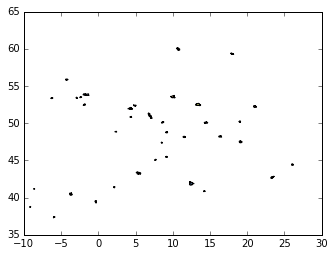

In [29]:
# * plot the geometries?
plt.figure(figsize=(18, 20))
geo_df.plot()

In [30]:
# * print out the wkt version of the geometries
wkts = map(lambda g: g.to_wkt() , geo_df.geometry)
wkts[0]

'MULTIPOLYGON (((8.5107307006359374 47.4321856995676399, 8.5246681998049585 47.4311641999393530, 8.5279242498929904 47.4326966806219446, 8.5435582019448226 47.4313431999938118, 8.5608377004806098 47.4184912001672032, 8.5632735628667263 47.4156632293667926, 8.5737861801280708 47.4113305375014278, 8.5877069538468671 47.4077497929542346, 8.5963697001261359 47.4056056998658448, 8.5946962009991807 47.3992081997123691, 8.5914807016822898 47.3970187004059866, 8.5881711997520256 47.3957447000301570, 8.5843452009833427 47.3918312003193023, 8.5830547017165344 47.3890491998953536, 8.5843612005403820 47.3883292000408147, 8.5851962017993984 47.3903277000466971, 8.5869666988020050 47.3901596998208490, 8.5930737000196906 47.3856432003684560, 8.5972052005078954 47.3784982000405037, 8.6036348410599501 47.3704819748861894, 8.6119942007658352 47.3669092004074415, 8.6216682005123886 47.3599741997193746, 8.6247997018888363 47.3543931996826970, 8.6220897006959447 47.3534011996904667, 8.6051131999004156 47.3

In [31]:
# * find out the Spatial Reference System (CRS/SRS) for the GeoDataframe?
# A note about CRS's and Geospatial Data.
# http://spatialreference.org/ref/epsg/etrs89-etrs-laea/
geo_df.crs

{'init': u'epsg:4258'}

In [32]:
# * change the reference system to a cartesian system that is suitable for calculating areas
# * calculate the total area of the cities we are using 
#   HINT: Europe using this CRS: http://spatialreference.org/ref/epsg/3035/
geo_df_cartesian = geo_df.to_crs(epsg=3035)
print geo_df_cartesian.crs
print geo_df.crs
geo_df_cartesian.area.sum()/1000000

{'init': 'epsg:3035', 'no_defs': True}
{'init': u'epsg:4258'}


12698.48169962045

In [33]:
# Add a WKT column for use later
geo_df['wkt'] = pandas.Series(
    map(lambda geom: str(geom.to_wkt()), geo_df['geometry']), 
    index=geo_df.index, dtype='string')

## Create a pyspark dataframe from GeoPanadas

Spark Dataframes are an abstraction over RDDs. Lets look at what happens when we call pyspark transform and action. 

**SLIDES Switch: Spark Internals**

![](images/pyspark.png)

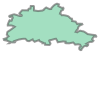

In [34]:
# https://spark.apache.org/docs/latest/api/python/pyspark.sql.html#pyspark.sql.SQLContext.createDataFrame
# Creates a DataFrame from an RDD of tuple/list, list or pandas.DataFrame.

# When schema is a list of column names, the type of each column will be inferred from data.

# When schema is None, it will try to infer the schema (column names and types) from data, which should
# be an RDD of Row, or namedtuple, or dict.

# If schema inference is needed, samplingRatio is used to determined the ratio of rows used for schema inference.
# The first row will be used if samplingRatio is None.

# Parameters:
# data – an RDD of Row/tuple/list/dict, list, or pandas.DataFrame.
# schema – a StructType or list of column names. default None.
# samplingRatio – the sample ratio of rows used for inferring
# Returns:
# DataFrame

boundries_from_pd = sqlContext.createDataFrame(geo_df)

# Lets find Berlin
berlin_rdd = boundries_from_pd.filter(boundries_from_pd.NAMEASCII == 'Berlin')
wkt.loads(berlin_rdd.take(1)[0].wkt)

### Exercise 

* Look at the schema of the boundries_from_pd
* Graph the name of the city and its population sorted


In [35]:
boundries_from_pd.printSchema()

df = boundries_from_pd.select(boundries_from_pd.NAMEASCII, 
                              boundries_from_pd.POPEU2013.cast(IntegerType())
                             )

df = df.sort(df.POPEU2013.desc())
df.show()

# SQL Version
boundries_from_pd.registerTempTable('boundries')
sqlContext.sql("SELECT NAME, POPEU2013 FROM boundries").show()

root
 |-- ADM0NAME: string (nullable = true)
 |-- ADM0_A3: string (nullable = true)
 |-- ADM1NAME: string (nullable = true)
 |-- ELEVATION: double (nullable = true)
 |-- FEATURECLA: string (nullable = true)
 |-- GEONAMEID: double (nullable = true)
 |-- GN_ASCII: string (nullable = true)
 |-- GN_POP: double (nullable = true)
 |-- ISO_A2: string (nullable = true)
 |-- MEGACITY: long (nullable = true)
 |-- NAME: string (nullable = true)
 |-- NAMEASCII: string (nullable = true)
 |-- POPEU2013: string (nullable = true)
 |-- TIMEZONE: string (nullable = true)
 |-- UN_FID: long (nullable = true)
 |-- URAU_CITY_: string (nullable = true)
 |-- geometry: struct (nullable = true)
 |    |-- __geom__: long (nullable = true)
 |    |-- _is_empty: boolean (nullable = true)
 |    |-- _ndim: long (nullable = true)
 |-- wkt: string (nullable = true)

+----------+---------+
| NAMEASCII|POPEU2013|
+----------+---------+
|    Berlin|  3375222|
|    Madrid|  3207247|
|      Rome|  2638842|
|     Paris|  2240

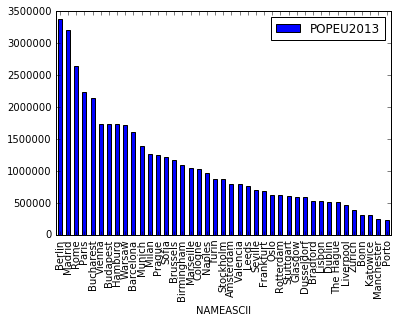

In [36]:
df = df.toPandas()

df.plot.bar(x='NAMEASCII')

# Lets look at the POI data next



In [37]:
pois_df = sqlContext.read.json(POIS_PATH)

print pois_df.count()
rec = pois_df.take(1)[0]
pois_df = pois_df.toPandas()
pois_df.count()


def toWktColumn(coords):
    return (Point(coords).wkt)

pois_df['wkt'] = pandas.Series(
    map(lambda geom: toWktColumn(geom.coordinates), pois_df['geometry']), 
    index=pois_df.index, dtype='string')

pois_df = sqlContext.createDataFrame(pois_df)

6956


# Count the number of museums in Zurich

## Exercise

* Count the number of museums in Zurich
HINT: You will need Shapely Spatial Operations


1358


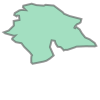

In [38]:
pois_df.registerTempTable("pois")
museums = sqlContext.sql(
    "SELECT geometry, \
    properties.name, \
    properties.tourism \
    FROM pois WHERE properties.tourism = 'museum'")
print museums.count()

# select museums within Zurich
zurich = sqlContext.sql("SELECT wkt, POPEU2013 \
    FROM boundries WHERE NAME = 'Zurich'")

jsonstr = zurich.toJSON().take(1)[0]
jsonobj = json.loads(jsonstr)
zurich_boundry = wkt.loads(jsonobj['wkt'])
zurich_boundry

In [39]:
museums_in_zurich = museums.rdd.filter(lambda r: Point(r['geometry']['coordinates']).within(zurich_boundry))
museums_in_zurich.count()

25

# SQL is nice but...

Most of the time in Spark SQL you can use Strings (in SQL) to reference columns but there are two cases where  you’ll want to use the Column objects rather than Strings :

* In Spark SQL DataFrame columns are allowed to have the same name, they’ll be given unique names inside of Spark SQL, but this means that you can’t reference them with the column name only as this becomes ambiguous.

* When you need to manipulate columns using expressions like Adding two columns to each other, Twice the value of this column or even Is the column value larger than 0 ?, you won’t be able to use simple strings and will need the Column reference.

* Finally if you need renaming, cast or any other complex feature, you’ll need the Column reference too.


# Joins, Spatial Predicate, Broadcast Variables, UDFs

In [40]:
# Exercise
# for each city count the number of museums
# and return a DF with:
# city_name, museum_count

# SQL VErsion
# cities_df = sqlContext.sql(
#     """
#     SELECT properties.NAMEASCII AS city_name, 
#         geometry AS city_geom FROM boundries
#     """)

cities_df = boundries_from_pd.select(
    (boundries_from_pd.NAMEASCII).alias('city_name'),
    (boundries_from_pd.wkt).alias('city_geom'))

cities_df.cache()

# Create a broadcast variable
# Broadcast http://spark.apache.org/docs/latest/programming-guide.html#broadcast-variables
# Broadcast variables allow the programmer to keep a read-only variable cached on each machine 
# rather than shipping a copy of it with tasks. They can be used, for example, to give every node 
# a copy of a large input dataset in an efficient manner. Spark also attempts to distribute broadcast
# variables using efficient broadcast algorithms to reduce communication cost.

# Spark actions are executed through a set of stages, separated by distributed “shuffle” 
# operations. Spark automatically broadcasts the common data needed by tasks within each stage. 
# The data broadcasted this way is cached in serialized form and deserialized before running each task. 
# This means that explicitly creating broadcast variables is only useful when tasks across multiple 
# stages need the same data or when caching the data in deserialized form is important.

# Broadcast variables are created from a variable v by calling SparkContext.broadcast(v). The broadcast 
# variable is a wrapper around v, and its value can be accessed by calling the value method.

_cities_df = cities_df.toJSON().collect()[0:3]
broadcastCitiesJSON = sc.broadcast(_cities_df)

# wkt.loads(json.loads(broadcastCitiesJSON.value[0])['city_geom'])

In [41]:
def get_city_name(poi_geom):
    # get an array of dict [(city_name, city_geom)]
    cities = map(lambda c: {
                    'city_name': json.loads(c)['city_name'],
                    'city_wkt': wkt.loads(json.loads(c)['city_geom'])
                }, broadcastCitiesJSON.value)

    shply_poi = shape(poi_geom.asDict())
    city = filter(lambda city: shply_poi.within(city['city_wkt']), cities)
    name = None
    if city:
        name = city[0]['city_name']
    return name

# http://spark.apache.org/docs/latest/api/python/pyspark.sql.html#pyspark.sql.SQLContext.registerFunction
# Registers a python function (including lambda function) as a UDF so it can be used in SQL statements.
# In addition to a name and the function itself, the return type can be optionally specified. When the 
# return type is not given it default to a string and conversion will automatically be done. For any other 
# return type, the produced object must match the specified type.

sqlContext.udf.register("get_city_name", get_city_name, StringType())

# http://spark.apache.org/docs/latest/api/python/pyspark.sql.html#pyspark.sql.functions.udf
# Creates a Column expression representing a user defined function (UDF).    
get_city_name_udf = func.udf(get_city_name, StringType())

# SQL VERSION
museums_df = sqlContext.sql(
     "SELECT geometry as museum_geom, \
     properties.name as museum_name, \
     get_city_name(geometry) as city_name \
     FROM pois WHERE properties.tourism = 'museum'")


#museums_df = pois_df.select(
#    (pois_df.geometry).alias('museum_geom'),
#    (pois_df.properties.name).alias('museum_name'),
#    (get_city_name_udf(pois_df.geometry).alias('city_name'))
#)

museums_df.registerTempTable("museums")
                       
print museums_df.count()
print cities_df.count()
print museums_df.where(museums_df.city_name.isNotNull()).count()


1358
41
112


In [42]:
museums_df.cache() # Try without and with
print museums_df.where(museums_df.city_name.isNotNull()).count()

112


 ## Grouping 

In [43]:
grouped_by_city = museums_df.dropna().groupBy('city_name')

In [44]:
grouped_by_city.count().show()

+---------+-----+
|city_name|count|
+---------+-----+
|   Prague|   78|
|   Zurich|   25|
|    Sofia|    6|
+---------+-----+



## Adding population column
Accoring to our algorithm we will have to divide count by the the population to scale it per capita. Lets try to run our algorithm on a subset of the data to get practice for the real deal!

In [45]:
# lets recreate the cities DF this time including the population
# http://spark.apache.org/docs/latest/api/python/pyspark.sql.html#pyspark.sql.Column.cast
# Convert the column into type dataType
cities_df = boundries_from_pd.select(
    (boundries_from_pd.NAMEASCII).alias('city_name'),
    (boundries_from_pd.POPEU2013.cast(IntegerType())).alias('population'),
    (boundries_from_pd.wkt).alias('city_geom'))

cities_df.cache()


DataFrame[city_name: string, population: int, city_geom: string]

In [46]:
museums_df = museums_df.dropna()

# http://spark.apache.org/docs/latest/api/python/pyspark.sql.html#pyspark.sql.DataFrame.join
# Joins with another DataFrame, using the given join expression.

# The following performs a full outer join between df1 and df2.

# Parameters:
# other – Right side of the join
# on – a string for join column name, a list of column names, , a join expression (Column) or a list of Columns.
#      If on is a string or a list of string indicating the name of the join column(s), the column(s) must exist 
#      on both sides, and this performs an equi-join.
# how – str, default ‘inner’. One of inner, outer, left_outer, right_outer, leftsemi.

df = museums_df.join(cities_df, museums_df.city_name == cities_df.city_name).select(
    museums_df.museum_geom,
    museums_df.museum_name,    
    museums_df.city_name,
    cities_df.population,
    cities_df.city_geom
)

df.printSchema( )
# Love Spark!

grouped_by_city = df.groupBy('city_name', 'population')
grouped_by_city = grouped_by_city.count()
            

root
 |-- museum_geom: struct (nullable = true)
 |    |-- coordinates: array (nullable = true)
 |    |    |-- element: double (containsNull = true)
 |    |-- type: string (nullable = true)
 |-- museum_name: string (nullable = true)
 |-- city_name: string (nullable = true)
 |-- population: integer (nullable = true)
 |-- city_geom: string (nullable = true)



## Calculating the score

In [47]:
# http://spark.apache.org/docs/latest/api/python/pyspark.sql.html#pyspark.sql.DataFrame.withColumnRenamed
grouped_by_city = grouped_by_city.withColumnRenamed('count', 'museum_count')

cultural_weight_lookup = { 'museum': 1, 'gallery': 2, 'artwork': 3 }

# http://spark.apache.org/docs/latest/api/python/pyspark.sql.html#pyspark.sql.DataFrame.withColumn
grouped_by_city = grouped_by_city.withColumn('cultural_score', (
                            grouped_by_city.museum_count/grouped_by_city.population
                           )*10000*cultural_weight_lookup['museum'])

In [48]:
grouped_by_city.show()

+---------+----------+------------+-------------------+
|city_name|population|museum_count|     cultural_score|
+---------+----------+------------+-------------------+
|   Prague|   1243201|          78| 0.6274126227375943|
|   Zurich|    380777|          25| 0.6565522602468111|
|    Sofia|   1213542|           6|0.04944204650518895|
+---------+----------+------------+-------------------+



In [49]:
# understanding de/serialization

from pyspark.rdd import RDD
dl = [
    (u'2', {u'director': u'David Lean'}), 
    (u'7', {u'director': u'Andrew Dominik'})
]

dl_rdd = sc.parallelize(dl)
tmp = dl_rdd._to_java_object_rdd()
tmp2 = sc._jvm.SerDe.javaToPython(tmp)
t = RDD(tmp2, sc)
t.count()

tmp = t._to_java_object_rdd()
tmp2 = sc._jvm.SerDe.javaToPython(tmp)
t = RDD(tmp2, sc)
t.count() 

2

# Spatial Spark

SpatialSpark aims to provide efficient spatial operations using Apache Spark. It can be used as a Spark library for spatial extension as well as a standalone application to process large scale spatial join operations.

SpatialSpark has been compiled and tested on Spark 1.6.1. For geometry operations and data structures for indexes, well known JTS library is used.

## Spatial Partition

Generate a spatial partition from input dataset, currently Fixed-Grid Partition (FGP), Binary-Split Partition (BSP) and Sort-Tile Partition (STP) are supported.

## Spatial Range Query

Spatial range query includes both indexed and non-indexed query. For non-indexed query, a full scan is performed on the dataset and returns filtered results. 

In [ ]:

print sc._jsc

In [ ]:
from ast import literal_eval as make_tuple
print "Java Spark context version:", sc._jsc.version()
spatialspark = sc._jvm.spatialspark

rectangleA = Polygon([(0, 0), (0, 10), (10, 10), (10, 0)])
rectangleB = Polygon([(-4, -4), (-4, 4), (4, 4), (4, -4)])
rectangleC = Polygon([(7, 7), (7, 8), (8, 8), (8, 7)])
pointD = Point((-1, -1))

def geomABWithId():
  return sc.parallelize([
    (0L, rectangleA.wkt),
    (1L, rectangleB.wkt)
  ])

def geomCWithId():
  return sc.parallelize([
    (0L, rectangleC.wkt)
  ])

def geomABCWithId():
  return sc.parallelize([
  (0L, rectangleA.wkt),
  (1L, rectangleB.wkt),
  (2L, rectangleC.wkt)])

def geomDWithId():
  return sc.parallelize([
    (0L, pointD.wkt)
  ])


dfAB = sqlContext.createDataFrame(geomABWithId(), ['id', 'wkt'])
dfABC = sqlContext.createDataFrame(geomABCWithId(), ['id', 'wkt'])
dfC = sqlContext.createDataFrame(geomCWithId(), ['id', 'wkt'])
dfD = sqlContext.createDataFrame(geomDWithId(), ['id', 'wkt'])
# Supported Operators: Within, WithinD, Contains, Intersects, Overlaps, NearestD
SpatialOperator      = spatialspark.operator.SpatialOperator 
BroadcastSpatialJoin = spatialspark.join.BroadcastSpatialJoin

joinRDD = BroadcastSpatialJoin.apply(sc._jsc, dfABC._jdf, dfAB._jdf, SpatialOperator.Within(), 0.0)

joinRDD.count()

In [ ]:
#results = joinRDD.collect()
#map(lambda result: make_tuple(result.toString()), results)

# [(0, 0), (1, 1), (2, 0)] read as:
# ID 0 is within 0
# ID 1 is within 1
# ID 2 is within 0

In [ ]:
# Exercise: Find out if geometry with ID 2 overlaps geometry with ID 1

# Perform Analysis on All Features and All Cities


In [ ]:
from pyspark.sql.functions import monotonically_increasing_id

# create dataframe with (id, geometry) for POIs
# 1. Add and ID Column to POIs

pois_df = pois_df.withColumn("id", monotonically_increasing_id())
pois_tuple_id_wkt = pois_df.select(pois_df.id, pois_df.wkt)
pois_tuple_id_wkt.show()
pois_tuple_id_wkt.printSchema()
print pois_tuple_id_wkt.count()

In [ ]:
boundries_from_pd = boundries_from_pd.withColumn("id", monotonically_increasing_id())
boundries_tuple_id_wkt = boundries_from_pd.select(boundries_from_pd.id, boundries_from_pd.wkt)
boundries_tuple_id_wkt.printSchema()
print boundries_from_pd.count()
boundries_tuple_id_wkt.show()
wkt.loads(boundries_tuple_id_wkt.take(1)[0].wkt)

In [ ]:
joinPoiBdryRDD = BroadcastSpatialJoin.apply(sc._jsc, 
                                            pois_tuple_id_wkt._jdf, 
                                            boundries_tuple_id_wkt._jdf, 
                                            SpatialOperator.Within(), 
                                            0.0)

In [ ]:
print joinPoiBdryRDD.count()

joinResults = map(lambda result: make_tuple(result.toString()), joinPoiBdryRDD.collect())


In [ ]:
print pois_tuple_id_wkt.count()
print boundries_tuple_id_wkt.count()
print joinResults[695]

In [ ]:
# make the results a DF
rddResult = sc.parallelize(joinResults)
df = sqlContext.createDataFrame(rddResult, ["poi_id", "boundry_id"])
df.printSchema()

In [ ]:
# Do a join with poi df and bdry df
df_with_pois = df.join(pois_df, df.poi_id == pois_df.id).select(
    df.poi_id,
    df.boundry_id,
    pois_df.properties.alias("poi_properties"),    
    pois_df.wkt.alias("poi_wkt")    

)


In [ ]:
df_with_pois.columns

In [ ]:
df_with_pois_bdrys = df_with_pois.join(boundries_from_pd, 
                                       df_with_pois.boundry_id == boundries_from_pd.id).select(
    df_with_pois.poi_id,
    df_with_pois.boundry_id,
    df_with_pois.poi_properties,
    df_with_pois.poi_wkt,
    boundries_from_pd.wkt.alias("boundry_wkt"),
    boundries_from_pd.NAMEASCII.alias("city_name"),
    boundries_from_pd.POPEU2013.alias("population")    
)

In [ ]:
df_with_pois_bdrys.columns

In [ ]:
df_with_pois_bdrys.cache()
df_with_pois_bdrys.count()

In [ ]:
df_with_pois_bdrys.show()

In [ ]:
rec = df_with_pois_bdrys.take(1)[0]

In [ ]:
print rec.poi_properties.amenity or rec.poi_properties.tourism

In [ ]:

df_with_pois_bdrys = df_with_pois_bdrys.withColumn(
        'tourism', df_with_pois_bdrys.poi_properties.tourism
    ).withColumn(
        'amenity', df_with_pois_bdrys.poi_properties.amenity)

df_with_pois_bdrys.show()

In [ ]:
# Create an expression for a column that calculates the score per record

# df_with_pois_bdrys.groupby("poi_properties.touris")

df = df_with_pois_bdrys.select('*', func.coalesce(
        df_with_pois_bdrys.poi_properties.tourism, df_with_pois_bdrys.poi_properties.amenity
    ).alias("location_type")).groupby('boundry_id', 'city_name', 'location_type', 'population').count()

In [ ]:
df.show()

In [ ]:
def get_cultural_score(location_type, count, population):
    cultural_weight_lookup = { u'museum': 1.0, u'arts_centre': 2.0, u'theatre': 3.0, u'gallery': 4.0, u'artwork': 5.0 }
    wgt = cultural_weight_lookup.get(location_type, 0.0)
    return float((wgt* float(count) * 100000)/float(population))

sqlContext.registerFunction("get_cultural_score", get_cultural_score, FloatType())

# score_udf = func.udf(get_cultural_score, FloatType())

In [ ]:
# score_df = df.select(df.boundry_id, 
#           df.city_name, 
#           df.population,
#           df.location_type,
#           df.count,
#           score_udf(df.location_type, df.count, df.population).alias('cultural_score')
#          )

In [ ]:
df.registerTempTable("cultural_score")

score_df = sqlContext.sql(
    "SELECT boundry_id, \
        city_name, \
        location_type, \
        population, \
        count, get_cultural_score(location_type, count, population) as score \
    FROM cultural_score")

In [ ]:
score_df.sort(score_df.city_name.asc()).show()
# score_df.show()

In [ ]:
df = score_df.groupBy("boundry_id", "city_name", "population").agg(func.sum(score_df.score)).sort("city_name")

In [ ]:
df.show()

In [ ]:
df= df.withColumnRenamed("sum(score)","final_score")

In [ ]:
df.show()

In [ ]:
pd = df.toPandas()
pd.sort_values("final_score", ascending=False)

In [ ]:
import folium
map_osm = folium.Map(location=[47.19094, 11.98566], 
    tiles='Stamen Toner',
    zoom_start=6)
map_osm

In [ ]:
pd_df = df_with_pois_bdrys.toPandas()
pd_df.head(2)

pd_df = pd_df[['boundry_id', 'boundry_wkt', 'city_name', 'population']]
pd_df = pd_df.drop_duplicates()

geometry = [wkt.loads(boundry_wkt) for boundry_wkt in pd_df.boundry_wkt]

geodf = GeoDataFrame(pd_df, geometry=geometry)

geodf.head(2)

scores = pd

scores.head()
scores_merged_df=pandas.DataFrame.merge(geodf, scores, on='boundry_id')

scores_merged_df.head(1)
geo_scores_merged = GeoDataFrame(scores_merged_df)

geo_scores_merged

import folium
map_osm = folium.Map(location=[47.19094, 11.98566], 
    tiles='Mapbox Bright',
    zoom_start=6)

map_osm.choropleth(geo_str=geo_scores_merged.to_json(),
              data=geo_scores_merged,
              columns=['city_name_x', 'final_score'],
              fill_color='BuPu',
              key_on='properties.city_name_x')
map_osm

In [ ]:
sc.stop()